In [67]:
print("ok")

ok


In [68]:
from langchain_openai import ChatOpenAI

In [69]:
from dotenv import load_dotenv

In [70]:
load_dotenv()

True

In [71]:
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [72]:
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [73]:
openai_model=ChatOpenAI(model="gpt-4o")

In [74]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BudzFhYNqA2GEnrdkJLn0qw9BGuJs', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1c6f9873-4fc9-417e-b4be-fafeb352487b-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [75]:
openai_model.invoke("hi").content

'Hello! How can I assist you today?'

In [90]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AnyMessage

In [91]:
state={}

In [92]:
state["messages"] = []

In [93]:
state

{'messages': []}

In [94]:
state["messages"].append("hi")

In [95]:
state

{'messages': ['hi']}

In [96]:
state["messages"].append("how are you?")

In [97]:
state

{'messages': ['hi', 'how are you?']}

In [98]:
state["messages"].append("what going on?")

In [99]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [100]:
state

{'messages': ['hi', 'how are you?', 'what going on?']}

In [101]:
state["messages"][0]

'hi'

In [102]:
state["messages"][-1]

'what going on?'

In [103]:
## this state is a dict which containing the message as list and inside the list there could be n numbvers of messages

## this state will be flowing across all the nodes(function) in langgraph

In [104]:
def call_model(state:MessagesState):
    question = state["messages"]
    response = openai_model.invoke(question)
    return {"messages":[response]}

In [105]:
## StateGraph
workflow = StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START,"chatbot")
workflow.add_edge("chatbot",END)
app = workflow.compile()

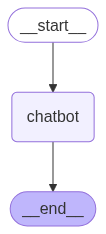

In [106]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [107]:
input={"messages":["hi my name is sunny"]}

In [108]:
response=app.invoke(input)

In [109]:
response["messages"][-1].content

'Hello Sunny! How can I assist you today?'

In [110]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content='Hello Sunny! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 12, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_3675863d82', 'id': 'chatcmpl-Bue0OIllaMProA1K0gJUpBSS5nEXl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6214e33-6d14-48b4-ba26-fe5c24ae3e0b-0', usage_metadata={'input_tokens': 12, 'output_tokens': 10, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}




In [111]:
@tool
def search(query:str):
    """this is a tool for weather checking"""
    if "india" in query.lower() or "delhi" in query.lower():
        return "the weather is hotty with some foggy"
    return "weather is cloudy with some darkness"

In [112]:
search.invoke("what is a weather in japan?")

'weather is cloudy with some darkness'

In [113]:
search.invoke("what is a weather in delhi?")

'the weather is hotty with some foggy'

In [114]:
tools = [search]

In [115]:
llm_with_tool = openai_model.bind_tools(tools)

In [116]:
response = llm_with_tool.invoke("hi")

In [117]:
response.content

'Hello! How can I assist you today?'

In [118]:
response.tool_calls

[]

In [119]:
result = llm_with_tool.invoke("what is a weather in europ?")

In [120]:
result.content

''

In [121]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'current weather in Europe'},
  'id': 'call_lQcJKL36gBM3SaTXxxPSGASp',
  'type': 'tool_call'}]

In [122]:
def call_model(state:MessagesState):
    question = state["messages"]
    response = llm_with_tool.invoke(question)
    return {"messages":[response]}

In [123]:
input = {'messages': ['hi my name is sunny']}

In [124]:
response = call_model(input)

In [125]:
message = response["messages"]

In [126]:
last_message=message[-1]

In [127]:
last_message.content

'Hello Sunny! How can I assist you today?'

In [128]:
last_message.tool_calls

[]

In [129]:
input={'messages': ['what is a weather in mumbai?']}

In [130]:
def router_function(state: MessagesState):
    message = state["messages"]
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [131]:
tools

[StructuredTool(name='search', description='this is a tool for weather checking', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001EBDF72A520>)]

In [132]:
tool_node = ToolNode(tools)

In [133]:
#StateGraph
workflow = StateGraph(MessagesState)
#Add the Node
workflow.add_node("assistant",call_model)
workflow.add_node("myweathertool",tool_node)
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "myweathertool", END: END})

app = workflow.compile()

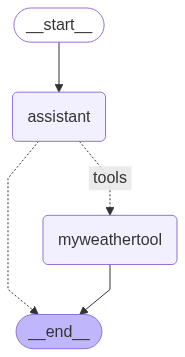

In [134]:
display(Image(app.get_graph().draw_mermaid_png()))

In [135]:
app.invoke({"messages": ["how are you?"]})

{'messages': [HumanMessage(content='how are you?', additional_kwargs={}, response_metadata={}, id='1ce604ca-d157-434c-a172-35daeed14342'),
  AIMessage(content="I'm just a computer program, so I don't have feelings, but thanks for asking! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 48, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bue0WgBR7znpKji3S5GvDUxUDAadl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--92d8c43e-fc40-46f7-b987-241febf9e997-0', usage_metadata={'input_tokens': 48, 'output_tokens': 25, 'total_tokens': 73, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {

In [136]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='44fa9062-d47d-43be-8d20-5e5463ba92ad'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DPeys8gEh4FUPvUyIgTMtIXj', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 52, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bue0XpQSJ1QXJoFMKNAZmjSN9lhJI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--773f9e52-570a-4754-a928-553c2f6f01f4-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'call_DPey

In [ ]:
workflow.add_edge("myweathertool","assistant")
app = workflow.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


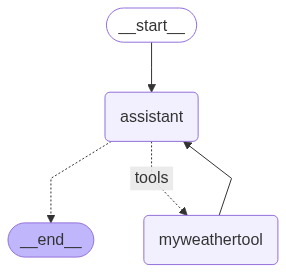

In [139]:
display(Image(app.get_graph().draw_mermaid_png()))

In [140]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='7ca6753d-3e38-452d-a310-4cde744eafc4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Drq9IrU925u0LP7foAWht9FK', 'function': {'arguments': '{"query":"Delhi weather"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 52, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bue0Z4PXo1OfVz199qd0kBrg79BMw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a749691e-207a-4a24-b9bb-e2b2c1c68c03-0', tool_calls=[{'name': 'search', 'args': {'query': 'Delhi weather'}, 'id': 'call_Drq9IrU925

In [141]:
for output in app.stream({"messages": ["what is the weather in delhi"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from assistant
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZSTpmJ4iDu7puwY1OVBtOs7J', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 51, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bue0c7rZexkTeqD8rnduvfSzcgMQj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--24e642b0-a720-4e3a-a619-f064893249af-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'call_ZSTpmJ4iDu7puwY1OVBtOs7J', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 15, '

In [ ]:
@tool
def multiply(a:int,b:int)->int:
    """multiply a and b"""
    return a*b

@tool
def add(a:int,b:int)->int:
    """adding two numbers a and b"""
    return a+b

@tool
def divide(a:int,b:int)->int:
    """dividing two numbers a and b"""
    return a/b

@tool
def subtract(a:int,b:int)->int:
    """subtracting two numbers a and b """
    return a-b



In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun
duckduckgo_search = DuckDuckGoSearchRun()
duckduckgo_search.invoke("who is a current prime minister of USA??")

In [ ]:
tools = [multiply, add, divide, subtract, duckduckgo_search]
llm_with_tools = openai_model.bind_tools(tools)

In [151]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001EBD72D20C0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001EBDF709520>, root_client=<openai.OpenAI object at 0x000001EBD708EFF0>, root_async_client=<openai.AsyncOpenAI object at 0x000001EBDF7093D0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'multiply a and b', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'adding two numbers a and b', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'dividing two numbers a and b', 

In [152]:
llm_with_tools.invoke("hi").tool_calls

[]

In [153]:
llm_with_tools.invoke("can you add these two number 5 and 40?").tool_calls

[{'name': 'add',
  'args': {'a': 5, 'b': 40},
  'id': 'call_DUBySqKK1VwXkuwvvRHmLhfn',
  'type': 'tool_call'}]

In [154]:
llm_with_tools.invoke("can you multiply these two number 5 and 40?").tool_calls

[{'name': 'multiply',
  'args': {'a': 5, 'b': 40},
  'id': 'call_VmsuGocq4JmndlWcZjmqpJiG',
  'type': 'tool_call'}]

In [155]:
llm_with_tools.invoke("can you divide these two number 5 and 40?").tool_calls

[{'name': 'divide',
  'args': {'a': 5, 'b': 40},
  'id': 'call_VLriG0nWfciitjskeLltqBL1',
  'type': 'tool_call'}]

In [156]:
llm_with_tools.invoke("what is a current gdp of india with current affaires").tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'current GDP of India 2023'},
  'id': 'call_SHhFVi30cVNI2yWLTK3YYJyd',
  'type': 'tool_call'}]

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
# System message
sys_msg = SystemMessage(content =
                        "You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."
                        )
     

In [159]:
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

In [ ]:
builder = StateGraph(MessagesState)
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"assistant")

In [164]:

from langgraph.prebuilt import tools_condition

In [165]:
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

In [ ]:
react_app = builder.compile()

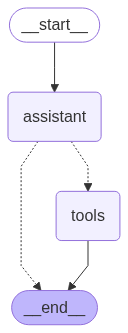

In [167]:
display(Image(react_app.get_graph().draw_mermaid_png()))

In [ ]:
builder.add_edge("tools","assistant")
react_app = builder.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


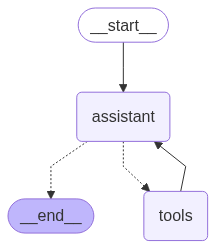

In [170]:
display(Image(react_app.get_graph().draw_mermaid_png()))

In [ ]:
message = [HumanMessage(content  =
            "what is twice of narendra modi's current age?")]

## this below detail is called a agentic flow
# first it will come to assistant
# then it will search narendra modi age
# then it will come to again assistant
# then it wil call the multiply tool for getting twice of age
# then again it will come to assistant 
# then it will generate a final answer

# REACT->> Reasoning+actions

# Thinking, action, observation, thiniking,action, observation---> if everything is going to be full fill
# then generating a final ans

In [ ]:
response = react_app.invoke({"messages":message})

c:\MY_Folder\Git_Folders\LANGGRAPH-UDEMY\U_agentic_ai\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


In [173]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is twice of narendra modi's current age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_6mt6fwSwFNxFVOBGMlL3UUEQ)
 Call ID: call_6mt6fwSwFNxFVOBGMlL3UUEQ
  Args:
    query: Narendra Modi age 2023
================================= Tool Message =================================
Name: duckduckgo_search

Sep 16, 2024 · Born as Narendra Damodardas Modi on September 17, 1950 in the nondescript Mehsana town of Gujarat, he served as the state’s CM for three consecutive terms (2001-14) … Sep 17, 2024 · At present, in 2024, Narendra Modi age is 74. Throughout his political career, Modi has been a significant figure, known for his leadership, vision, and constructive policies. His … Jul 11, 2025 · However, Union Home Minister Amit Shah, in May 2023, had dismissed any such age bar, asserting that the BJP’s constitution does not include a ret

In [ ]:
messages = [HumanMessage(content="hi hello how are you?")]
response = react_app.invoke({"messages":messages})

In [176]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi hello how are you?
================================== Ai Message ==================================

Hello! I'm just a virtual assistant, but I'm here to help you. How can I assist you today?


1. humanmessage
2. ai mesage:toolcall
3. duckcuk
4. ai assistant
5. sustract
6. ai
7. final answer

In [177]:
messages=[HumanMessage(content="what is current gdp of china and india can you give me difference between them?")]

In [178]:
response=react_app.invoke({"messages":messages})

c:\MY_Folder\Git_Folders\LANGGRAPH-UDEMY\U_agentic_ai\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\MY_Folder\Git_Folders\LANGGRAPH-UDEMY\U_agentic_ai\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\MY_Folder\Git_Folders\LANGGRAPH-UDEMY\U_agentic_ai\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


In [179]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is current gdp of china and india can you give me difference between them?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_O0TTazDaTGqtgR8rLYt9xwqx)
 Call ID: call_O0TTazDaTGqtgR8rLYt9xwqx
  Args:
    query: current GDP of China 2023
  duckduckgo_search (call_6Muyf7AtekMFnKVQhhBgBPf1)
 Call ID: call_6Muyf7AtekMFnKVQhhBgBPf1
  Args:
    query: current GDP of India 2023
================================= Tool Message =================================
Name: duckduckgo_search

Oct 27, 2024 · GDP (Nominal), GDP (PPP), GDP (Nominal) per capita, GDP (PPP) per capita, GDP Growth and rank in 2023. Data source is International Monetary Fund World Economic … Dec 26, 2024 · China revised upwards its 2023 gross domestic product (GDP) by 2.7% to 129.4 trillion yuan ($17.73 trillion), a top statistics official said on Thursday, while releasing th

As of 2023, China's GDP is approximately $17.73 trillion, while India's GDP is about $3.9 trillion. The difference in their GDPs is approximately $13.83 trillion, with China's economy being larger than India's by this amount.

In [181]:
# project:rag,agent,deployment,modularcoding,ci/cd,git

# multiagentic collrabtive agent and supoervisor agent



Reaserch and analsysis react agent: assisgnment
1. llm assistant
2. take a realtime weather api to check the real time weather detail
3. take a realtime api for checking realtime cricket score
4. take a tool for analysis the generated data(REPL)python code
5. create a report based on the generated data
memory
human in loop
multiagentic flow


from next week onwards will implemnt the project

## 1. langgraph-> memeory saver, human in loop
## 2. multiagents

In [182]:

from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [219]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [ ]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults(tavily_api_key="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")
    result=tavily.invoke(query)
    return result    

In [187]:
search.invoke("who is a current PM in india?")

C:\Users\Mohan\AppData\Local\Temp\ipykernel_12548\418483333.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults(tavily_api_key="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")


[{'title': 'List of all Prime Ministers of India (1947-2025) - Jagran Josh',
  'url': 'https://www.jagranjosh.com/general-knowledge/list-of-all-prime-ministers-of-india-1473165149-1',
  'content': "They are in charge of forming the cabinet, making important decisions, and representing India in the world. The Prime Minister leads the country’s policies and ensures that the government works smoothly.\n\n Currently, Narendra Modi is the Prime Minister of India, having been in office since 2014. He is the 14th Prime Minister of India who had three consecutive terms on the post. He took the Prime Minister's Oath on June 9, 2024. [...] ## List of all the Prime Ministers of India from 1947-2025\n\nIndia has been governed by 14 prime ministers over the years. Currently, Narendra Modi is serving his third term as Prime Minister in 2024, continuing his leadership journey that started in 2014.\n\nKnown for major reforms like GST, Make in India, and Swachh Bharat, Modi's tenure also included bold 

In [ ]:
tools = [search,multiply]
model_with_tools = openai_model.bind_tools(tools)

In [190]:
model_with_tools.invoke("who is a cuurent pm of japan?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CMIS6wyhqK6oYR2FVlEzxgzw', 'function': {'arguments': '{"query":"Current Prime Minister of Japan October 2023"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 78, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bue4esshUBemlgGCaWhCE74yYkTiO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cd249a40-f342-48a1-a9fd-3003f6c2d1c8-0', tool_calls=[{'name': 'search', 'args': {'query': 'Current Prime Minister of Japan October 2023'}, 'id': 'call_CMIS6wyhqK6oYR2FVlEzxgzw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output

In [191]:
model_with_tools.invoke("who is a cuurent pm of japan?").tool_calls

[{'name': 'search',
  'args': {'query': 'current Prime Minister of Japan 2023'},
  'id': 'call_TnwhZJstau87hsi9BhOhDUZu',
  'type': 'tool_call'}]

In [ ]:
tool_mapping = {tool.name: tool for tool in tools}

In [193]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001EBDF1F7240>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001EBD229FA60>)}

In [ ]:
response = model_with_tools.invoke("who is a current president of uk?")

In [195]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j4IRBe4wz4OLNTH7nk0TdHYX', 'function': {'arguments': '{"query":"current President of the UK 2023"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 77, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bue4gcT00Ih0yn1zP3xtoJkXpBZ8g', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1dd2f176-a211-42fc-b40e-8db3859889b6-0', tool_calls=[{'name': 'search', 'args': {'query': 'current President of the UK 2023'}, 'id': 'call_j4IRBe4wz4OLNTH7nk0TdHYX', 'type': 'tool_call'}], usage_metadata={'input_tokens': 77, 'output_tokens': 20, 'total_tok

In [ ]:
tool_details =  response.additional_kwargs

In [197]:
tool_details

{'tool_calls': [{'id': 'call_j4IRBe4wz4OLNTH7nk0TdHYX',
   'function': {'arguments': '{"query":"current President of the UK 2023"}',
    'name': 'search'},
   'type': 'function'}],
 'refusal': None}

In [ ]:
tool_details = tool_details.get("tool_calls")

In [199]:
tool_details[0]["function"]["name"]

'search'

In [200]:
tool_details[0]["function"]["arguments"]

'{"query":"current President of the UK 2023"}'

In [201]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'current President of the UK 2023'}

In [202]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'title': 'Rishi Sunak | Biography, Wife, Politics, & Net Worth - Britannica',
  'url': 'https://www.britannica.com/biography/Rishi-Sunak',
  'content': 'In March 2023 Sunak held off a Tory rebellion and passed the so-called Windsor Framework, a post-Brexit deal to regulate trade between Northern Ireland, the rest of the United Kingdom, and the European Union. During his campaign to drum up support for the bill, Sunak stressed the “privileged access, not just to the U.K. home market, which is enormous, but also the EU single market” that Northern Ireland would enjoy under the framework. Critics were quick to observe that, prior to Brexit, the [...] In November 2023 Sunak sacked controversial home secretary Suella Braverman as part of a broader cabinet reshuffle that saw the stunning return to government of former prime minister David Cameron as foreign secretary. Cameron, who was elevated to the House of Lords and created Lord Cameron of Chipping Norton in order to take his seat in th

In [203]:
tool_mapping={tool.name: tool for tool in tools}

In [204]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001EBDF1F7240>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001EBD229FA60>)}

In [225]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]

In [226]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [227]:
def invoke_tool(state:AgentState):
    print("****my state*****")
    print(state['messages'][-1])
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        print("**********tool detils****")
        print(tool_details)
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}
     

In [228]:
def router(state:AgentState):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"
     

In [229]:
graph = StateGraph(AgentState)
graph.add_node("ai_assistant",invoke_model)
graph.add_node("tool",invoke_tool)
graph.add_conditional_edges("ai_assistant",
                            router,
                            {"tool":"tool",
                             "end":END})
graph.add_edge("tool", END)

# graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")
## Compile the Graph
app = graph.compile()


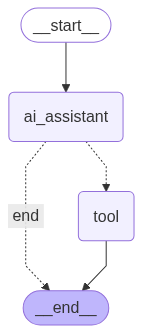

In [230]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [231]:
app.invoke({"messages": ["who is upcoming president of USA?"]})

****my state*****
content='' additional_kwargs={'tool_calls': [{'id': 'call_MJtQrYkLNx83b5pYVYNeKOpD', 'function': {'arguments': '{"query":"upcoming president of USA 2024"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 76, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bue8v6WQXTXf9ydSNQLUM8NygPtwD', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--3f8772dc-c9c7-4a40-ad55-2b113485a9a6-0' tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA 2024'}, 'id': 'call_MJtQrYkLNx83b5pYVYNeKOpD', 'type': 'tool_call'}] usage_metadata={'input_tokens': 76, 'output_tokens': 20, 'total_toke

TypeError: 'dict' object is not callable

In [ ]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w1GRDpV3kS2tQNclIQia2NwY', 'function': {'arguments': '{"query":"upcoming president of USA 2024"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 76, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bue7ragAXve5oxfldPQ3diAbapUur', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4781e01d-1cc0-45a6-9dc5-1a17b603e239-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA 2024'}, 'id': 'call_w1GRDpV3kS2tQNclIQia2NwY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 'output_tokens': 20, 

TypeError: 'dict' object is not callable

In [ ]:
app.invoke({"messages": ["what is multiplication of 23 and 46?"]})

****my state*****
content='' additional_kwargs={'tool_calls': [{'id': 'call_nR3ZuRvEX6nAdQul1NSm7pJH', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 79, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_22890b9c0a', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-4b20b0f0-5c68-4616-bb58-9b24e97fdaa9-0' tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_nR3ZuRvEX6nAdQul1NSm7pJH', 'type': 'tool_call'}] usage_metadata={'input_tokens': 79, 'output_tokens': 20, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_d

{'messages': ['what is multiplication of 23 and 46?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nR3ZuRvEX6nAdQul1NSm7pJH', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 79, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_22890b9c0a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4b20b0f0-5c68-4616-bb58-9b24e97fdaa9-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_nR3ZuRvEX6nAdQul1NSm7pJH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 79, 'output_tokens': 20, 'total_tokens': 99, 'input_token_det

In [ ]:
app.invoke({"messages": ["what is today's match score?"]})

****my state*****
content='' additional_kwargs={'tool_calls': [{'id': 'call_v3doO6lnvRtS3MM1B9v2viGT', 'function': {'arguments': '{"query":"today\'s match score"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 75, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_22890b9c0a', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-9ed12faa-1174-4f85-b9ef-e39c73836080-0' tool_calls=[{'name': 'search', 'args': {'query': "today's match score"}, 'id': 'call_v3doO6lnvRtS3MM1B9v2viGT', 'type': 'tool_call'}] usage_metadata={'input_tokens': 75, 'output_tokens': 17, 'total_tokens': 92, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 

{'messages': ["what is today's match score?",
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v3doO6lnvRtS3MM1B9v2viGT', 'function': {'arguments': '{"query":"today\'s match score"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 75, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_22890b9c0a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9ed12faa-1174-4f85-b9ef-e39c73836080-0', tool_calls=[{'name': 'search', 'args': {'query': "today's match score"}, 'id': 'call_v3doO6lnvRtS3MM1B9v2viGT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 75, 'output_tokens': 17, 'total_tokens': 92, 'input_token_details': {'audio': 0, 'cache_